In [1]:
import pandas as pd
import nltk.data
import numpy as np
import matplotlib.pyplot as plt # plot figures
from nltk.corpus import PlaintextCorpusReader
import os, time, random, re, codecs, spacy, math, torch, spacy, transformers, nltk
from os.path import join
import seaborn as sns # plot figures
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from ipywidgets import IntProgress
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_roc_curve
from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import load_model
from sklearn.model_selection import GridSearchCV
from transformers import AdamW
import torch.optim as optim
import codecs, json, copy
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM, BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore') 
import copy
import glob

In [2]:
path = '....csv'
df = pd.read_csv(path)
df = df.drop(df.columns[0], axis=1)
# df

In [3]:
path_2 = '....csv'
df_2 = pd.read_csv(path_2)
df_2 = df_2.drop(df_2.columns[0], axis=1)
# df_2

In [4]:
# Seeding:
def seed_all(seed):  
    ''' A function to seed everything for getting stable results and reproducibility'''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed = 2021    
seed_all(seed)
# Testing size:
sizeoftest = 0.2

In [5]:
df.shape

(447, 5)

In [6]:
print(df.columns.tolist()) # column names

['end', 'file_key', 'label', 'start', 'str']


In [7]:
df.dtypes

end          int64
file_key     int64
label        int64
start        int64
str         object
dtype: object

In [8]:
df.isnull().any()

end         False
file_key    False
label       False
start       False
str         False
dtype: bool

In [9]:
df['label'].value_counts()

1    356
0     91
Name: label, dtype: int64

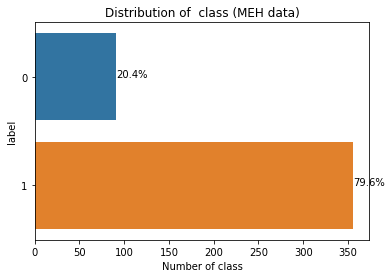

In [10]:
ax = sns.countplot(y="label", data=df)
plt.title('Distribution of  class (MEH data)')
plt.xlabel('Number of class')
total = len(df['label'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
# plt.savefig('class_label')
plt.show()

In [11]:
texts = df['str'].tolist()
labels = df['label'].tolist()
X, X_test, y, y_test = train_test_split(texts,
                                        labels,
                                        test_size=0.2,
                                        train_size=0.8,
                                        random_state=seed)
X_train, X_dev, y_train, y_dev = train_test_split(X,
                                                  y,
                                                  test_size=0.25,
                                                  train_size=0.75,
                                                  random_state=seed)
# len(X_train), len(y_train), len(X_test), len(y_test), len(X_dev), len(y_dev)
print("Train size:", len(X_train))
print("Dev size:", len(X_dev))
print("Test size:", len(X_test))

Train size: 267
Dev size: 90
Test size: 90


# BERT model
## Initial training

In [12]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

In [14]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

In [15]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

In [16]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert = bert 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [17]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

In [18]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

In [22]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [23]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████| 54/54 [00:01<00:00, 29.61it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.40it/s]


Training Loss: 0.372 dev performance, p:0.918, r:0.985, f1:0.950
current best score is 0.950

 Epoch 2 / 20



100%|██████████| 54/54 [00:01<00:00, 30.07it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.47it/s]


Training Loss: 0.280 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 3 / 20



100%|██████████| 54/54 [00:01<00:00, 30.07it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.25it/s]


Training Loss: 0.291 dev performance, p:0.919, r:1.000, f1:0.958
current best score is 0.958

 Epoch 4 / 20



100%|██████████| 54/54 [00:01<00:00, 30.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.30it/s]


Training Loss: 0.284 dev performance, p:0.931, r:0.985, f1:0.957

 Epoch 5 / 20



100%|██████████| 54/54 [00:01<00:00, 30.28it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.18it/s]


Training Loss: 0.260 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 6 / 20



100%|██████████| 54/54 [00:01<00:00, 29.05it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 89.08it/s]


Training Loss: 0.232 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 7 / 20



100%|██████████| 54/54 [00:01<00:00, 29.51it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 113.01it/s]


Training Loss: 0.222 dev performance, p:0.919, r:1.000, f1:0.958

 Epoch 8 / 20



100%|██████████| 54/54 [00:01<00:00, 30.36it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.35it/s]


Training Loss: 0.195 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 9 / 20



100%|██████████| 54/54 [00:01<00:00, 30.43it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.99it/s]


Training Loss: 0.222 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 10 / 20



100%|██████████| 54/54 [00:01<00:00, 29.90it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.64it/s]


Training Loss: 0.175 dev performance, p:0.926, r:0.926, f1:0.926

 Epoch 11 / 20



100%|██████████| 54/54 [00:01<00:00, 30.00it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.81it/s]


Training Loss: 0.220 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 12 / 20



100%|██████████| 54/54 [00:01<00:00, 30.62it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 102.12it/s]


Training Loss: 0.197 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 13 / 20



100%|██████████| 54/54 [00:01<00:00, 30.58it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 101.85it/s]


Training Loss: 0.201 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 14 / 20



100%|██████████| 54/54 [00:01<00:00, 30.37it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 101.87it/s]


Training Loss: 0.184 dev performance, p:0.925, r:0.912, f1:0.919

 Epoch 15 / 20



100%|██████████| 54/54 [00:01<00:00, 30.69it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.37it/s]


Training Loss: 0.175 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 16 / 20



100%|██████████| 54/54 [00:01<00:00, 30.84it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 101.93it/s]


Training Loss: 0.213 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 17 / 20



100%|██████████| 54/54 [00:01<00:00, 30.69it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 102.02it/s]


Training Loss: 0.215 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 18 / 20



100%|██████████| 54/54 [00:01<00:00, 30.85it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 107.82it/s]


Training Loss: 0.203 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 19 / 20



100%|██████████| 54/54 [00:01<00:00, 30.64it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.08it/s]


Training Loss: 0.212 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 20 / 20



100%|██████████| 54/54 [00:01<00:00, 30.53it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.70it/s]


Training Loss: 0.157 dev performance, p:0.984, r:0.912, f1:0.947


In [24]:
model_file = 'MEH_bert_initial.pt'
torch.save(best_model_state, model_file)

In [25]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'MEH_bert_initial.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

In [26]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [27]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 18/18 [00:00<00:00, 110.77it/s]

{'precision': 0.9722222222222222, 'recall': 0.9333333333333333, 'f1': 0.9523809523809524}


In [28]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))
# report_BERT1 = classification_report(test_y, preds)
# classification_report_csv(report_BERT1)

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.96      0.93      0.95        75

    accuracy                           0.91        90
   macro avg       0.83      0.87      0.85        90
weighted avg       0.92      0.91      0.91        90



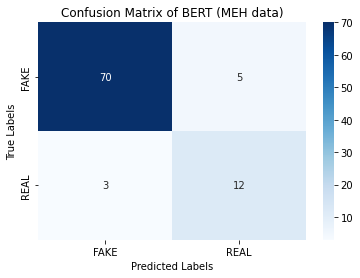

In [29]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT (MEH data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_bert_meh')

## Fine-tuning

In [30]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [31]:
# %%time
# from bert import run_classifier
params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# wrap classifier/regressor in GridSearchCV
clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
                   params,
                   cv=3,
                   scoring='accuracy',
                   verbose=True)

# fit gridsearch 
clf_bert.fit(X_train ,y_train)

Building sklearn text classifier...
Building sklearn text classifier...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 16.38it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 15.38it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 14.68it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 14.76it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 14.36it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 14.04it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 13.86it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 13.57it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 13.58it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 13.00it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:00<00:00, 12.25it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 11.60it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 11.33it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 11.63it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 11.11it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.91it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.50it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.15it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.26it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.32it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00, 10.49it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.96it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.65it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.31it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.53it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.40it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  9.46it/s]


Building sklearn text classifier...
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 267, validation data size: 0


Training  : 100%|██████████| 9/9 [00:03<00:00,  2.29it/s, loss=0.089] 


GridSearchCV(cv=3,
             estimator=BertClassifier(max_seq_length=64, validation_fraction=0),
             param_grid={'epochs': [50, 75, 100],
                         'learning_rate': [2e-05, 3e-05, 1e-05]},
             scoring='accuracy', verbose=True)

In [32]:
means = clf_bert.cv_results_['mean_test_score']
stds = clf_bert.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
# best scores
print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

0.918 (+/-0.046) for {'epochs': 50, 'learning_rate': 2e-05}
0.921 (+/-0.055) for {'epochs': 50, 'learning_rate': 3e-05}
0.918 (+/-0.046) for {'epochs': 50, 'learning_rate': 1e-05}
0.921 (+/-0.049) for {'epochs': 75, 'learning_rate': 2e-05}
0.918 (+/-0.046) for {'epochs': 75, 'learning_rate': 3e-05}
0.914 (+/-0.046) for {'epochs': 75, 'learning_rate': 1e-05}
0.921 (+/-0.037) for {'epochs': 100, 'learning_rate': 2e-05}
0.918 (+/-0.038) for {'epochs': 100, 'learning_rate': 3e-05}
0.918 (+/-0.038) for {'epochs': 100, 'learning_rate': 1e-05}

Best score: 0.9213483146067416 with params: {'epochs': 50, 'learning_rate': 3e-05}


In [33]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# Print state of GPU
# !nvidia-smi

'Tesla P100-PCIE-16GB'

In [34]:
#define a batch size
batch_size = 5
epochs = 50
learning_rate = 3e-5

In [35]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [36]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 50


100%|██████████| 54/54 [00:02<00:00, 23.77it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 81.26it/s]


Training Loss: 0.550 dev performance, p:0.808, r:0.926, f1:0.863
current best score is 0.863

 Epoch 2 / 50



100%|██████████| 54/54 [00:02<00:00, 23.72it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.77it/s]


Training Loss: 0.543 dev performance, p:0.787, r:0.926, f1:0.851

 Epoch 3 / 50



100%|██████████| 54/54 [00:02<00:00, 23.78it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.76it/s]


Training Loss: 0.540 dev performance, p:0.818, r:0.926, f1:0.869
current best score is 0.869

 Epoch 4 / 50



100%|██████████| 54/54 [00:02<00:00, 23.81it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 81.92it/s]


Training Loss: 0.532 dev performance, p:0.785, r:0.912, f1:0.844

 Epoch 5 / 50



100%|██████████| 54/54 [00:02<00:00, 23.81it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.13it/s]


Training Loss: 0.523 dev performance, p:0.778, r:0.926, f1:0.846

 Epoch 6 / 50



100%|██████████| 54/54 [00:02<00:00, 23.89it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.26it/s]


Training Loss: 0.521 dev performance, p:0.797, r:0.926, f1:0.857

 Epoch 7 / 50



100%|██████████| 54/54 [00:02<00:00, 23.89it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.49it/s]


Training Loss: 0.507 dev performance, p:0.816, r:0.912, f1:0.861

 Epoch 8 / 50



100%|██████████| 54/54 [00:02<00:00, 23.91it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.99it/s]


Training Loss: 0.507 dev performance, p:0.797, r:0.926, f1:0.857

 Epoch 9 / 50



100%|██████████| 54/54 [00:02<00:00, 23.83it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.58it/s]


Training Loss: 0.502 dev performance, p:0.865, r:0.941, f1:0.901
current best score is 0.901

 Epoch 10 / 50



100%|██████████| 54/54 [00:02<00:00, 23.98it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.94it/s]


Training Loss: 0.487 dev performance, p:0.797, r:0.926, f1:0.857

 Epoch 11 / 50



100%|██████████| 54/54 [00:02<00:00, 23.98it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.73it/s]


Training Loss: 0.486 dev performance, p:0.797, r:0.926, f1:0.857

 Epoch 12 / 50



100%|██████████| 54/54 [00:01<00:00, 28.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.66it/s]


Training Loss: 0.477 dev performance, p:0.816, r:0.912, f1:0.861

 Epoch 13 / 50



100%|██████████| 54/54 [00:01<00:00, 29.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.26it/s]


Training Loss: 0.478 dev performance, p:0.808, r:0.926, f1:0.863

 Epoch 14 / 50



100%|██████████| 54/54 [00:01<00:00, 28.94it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.58it/s]


Training Loss: 0.466 dev performance, p:0.829, r:0.926, f1:0.875

 Epoch 15 / 50



100%|██████████| 54/54 [00:01<00:00, 28.93it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.39it/s]


Training Loss: 0.459 dev performance, p:0.821, r:0.941, f1:0.877

 Epoch 16 / 50



100%|██████████| 54/54 [00:01<00:00, 28.55it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 109.52it/s]


Training Loss: 0.458 dev performance, p:0.842, r:0.941, f1:0.889

 Epoch 17 / 50



100%|██████████| 54/54 [00:01<00:00, 28.90it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 109.35it/s]


Training Loss: 0.454 dev performance, p:0.829, r:0.926, f1:0.875

 Epoch 18 / 50



100%|██████████| 54/54 [00:01<00:00, 28.95it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 109.31it/s]


Training Loss: 0.445 dev performance, p:0.821, r:0.941, f1:0.877

 Epoch 19 / 50



100%|██████████| 54/54 [00:01<00:00, 28.95it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.69it/s]


Training Loss: 0.443 dev performance, p:0.875, r:0.926, f1:0.900

 Epoch 20 / 50



100%|██████████| 54/54 [00:01<00:00, 28.97it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.14it/s]


Training Loss: 0.437 dev performance, p:0.829, r:0.926, f1:0.875

 Epoch 21 / 50



100%|██████████| 54/54 [00:01<00:00, 28.74it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.13it/s]


Training Loss: 0.430 dev performance, p:0.875, r:0.926, f1:0.900

 Epoch 22 / 50



100%|██████████| 54/54 [00:01<00:00, 28.78it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.57it/s]


Training Loss: 0.420 dev performance, p:0.853, r:0.941, f1:0.895

 Epoch 23 / 50



100%|██████████| 54/54 [00:01<00:00, 28.28it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.51it/s]


Training Loss: 0.418 dev performance, p:0.810, r:0.941, f1:0.871

 Epoch 24 / 50



100%|██████████| 54/54 [00:02<00:00, 23.76it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 87.31it/s]


Training Loss: 0.413 dev performance, p:0.890, r:0.956, f1:0.922
current best score is 0.922

 Epoch 25 / 50



100%|██████████| 54/54 [00:02<00:00, 23.78it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.42it/s]


Training Loss: 0.412 dev performance, p:0.863, r:0.926, f1:0.894

 Epoch 26 / 50



100%|██████████| 54/54 [00:02<00:00, 24.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.21it/s]


Training Loss: 0.405 dev performance, p:0.878, r:0.956, f1:0.915

 Epoch 27 / 50



100%|██████████| 54/54 [00:01<00:00, 28.58it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.50it/s]


Training Loss: 0.402 dev performance, p:0.855, r:0.956, f1:0.903

 Epoch 28 / 50



100%|██████████| 54/54 [00:01<00:00, 28.63it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.40it/s]


Training Loss: 0.397 dev performance, p:0.875, r:0.926, f1:0.900

 Epoch 29 / 50



100%|██████████| 54/54 [00:01<00:00, 28.82it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 109.97it/s]


Training Loss: 0.400 dev performance, p:0.900, r:0.926, f1:0.913

 Epoch 30 / 50



100%|██████████| 54/54 [00:01<00:00, 28.57it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.42it/s]


Training Loss: 0.391 dev performance, p:0.863, r:0.926, f1:0.894

 Epoch 31 / 50



100%|██████████| 54/54 [00:01<00:00, 28.76it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.52it/s]


Training Loss: 0.382 dev performance, p:0.889, r:0.941, f1:0.914

 Epoch 32 / 50



100%|██████████| 54/54 [00:01<00:00, 28.62it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.31it/s]


Training Loss: 0.380 dev performance, p:0.867, r:0.956, f1:0.909

 Epoch 33 / 50



100%|██████████| 54/54 [00:01<00:00, 27.19it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.29it/s]


Training Loss: 0.378 dev performance, p:0.915, r:0.956, f1:0.935
current best score is 0.935

 Epoch 34 / 50



100%|██████████| 54/54 [00:02<00:00, 24.00it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 82.47it/s]


Training Loss: 0.372 dev performance, p:0.915, r:0.956, f1:0.935

 Epoch 35 / 50



100%|██████████| 54/54 [00:02<00:00, 23.80it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.84it/s]


Training Loss: 0.368 dev performance, p:0.913, r:0.926, f1:0.920

 Epoch 36 / 50



100%|██████████| 54/54 [00:02<00:00, 24.01it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.78it/s]


Training Loss: 0.367 dev performance, p:0.901, r:0.941, f1:0.921

 Epoch 37 / 50



100%|██████████| 54/54 [00:02<00:00, 23.79it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.85it/s]


Training Loss: 0.362 dev performance, p:0.917, r:0.971, f1:0.943
current best score is 0.943

 Epoch 38 / 50



100%|██████████| 54/54 [00:02<00:00, 25.44it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.39it/s]


Training Loss: 0.359 dev performance, p:0.969, r:0.912, f1:0.939

 Epoch 39 / 50



100%|██████████| 54/54 [00:02<00:00, 25.72it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.88it/s]


Training Loss: 0.353 dev performance, p:0.926, r:0.926, f1:0.926

 Epoch 40 / 50



100%|██████████| 54/54 [00:02<00:00, 25.37it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 94.04it/s] 


Training Loss: 0.350 dev performance, p:0.943, r:0.971, f1:0.957


current best score is 0.957

 Epoch 41 / 50


100%|██████████| 54/54 [00:02<00:00, 25.47it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.18it/s]


Training Loss: 0.351 dev performance, p:0.887, r:0.926, f1:0.906

 Epoch 42 / 50



100%|██████████| 54/54 [00:02<00:00, 25.94it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.18it/s]


Training Loss: 0.342 dev performance, p:0.903, r:0.956, f1:0.929

 Epoch 43 / 50



100%|██████████| 54/54 [00:02<00:00, 25.89it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.50it/s]


Training Loss: 0.339 dev performance, p:0.929, r:0.956, f1:0.942

 Epoch 44 / 50



100%|██████████| 54/54 [00:02<00:00, 25.94it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.07it/s]


Training Loss: 0.341 dev performance, p:0.890, r:0.956, f1:0.922

 Epoch 45 / 50



100%|██████████| 54/54 [00:02<00:00, 25.87it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.05it/s]


Training Loss: 0.333 dev performance, p:0.943, r:0.971, f1:0.957

 Epoch 46 / 50



100%|██████████| 54/54 [00:02<00:00, 25.78it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.86it/s]


Training Loss: 0.337 dev performance, p:0.941, r:0.941, f1:0.941

 Epoch 47 / 50



100%|██████████| 54/54 [00:02<00:00, 25.51it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 94.22it/s]


Training Loss: 0.330 dev performance, p:0.942, r:0.956, f1:0.949

 Epoch 48 / 50



100%|██████████| 54/54 [00:02<00:00, 25.62it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 94.55it/s] 


Training Loss: 0.326 dev performance, p:0.941, r:0.941, f1:0.941

 Epoch 49 / 50



100%|██████████| 54/54 [00:02<00:00, 25.45it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.78it/s]


Training Loss: 0.325 dev performance, p:0.928, r:0.941, f1:0.934

 Epoch 50 / 50



100%|██████████| 54/54 [00:02<00:00, 25.66it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.99it/s]


Training Loss: 0.327 dev performance, p:0.941, r:0.941, f1:0.941


In [37]:
model_file = 'MEH_bert_gridsearch.pt'
torch.save(best_model_state, model_file)

In [38]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'MEH_bert_gridsearch.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

In [39]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [40]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 18/18 [00:00<00:00, 110.24it/s]

{'precision': 0.9466666666666667, 'recall': 0.9466666666666667, 'f1': 0.9466666666666667}


In [41]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.95      0.95      0.95        75

    accuracy                           0.91        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.91      0.91      0.91        90



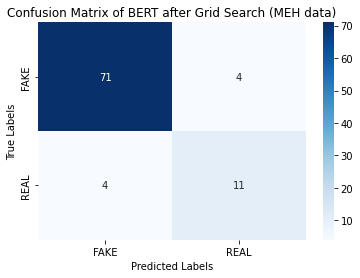

In [42]:
cm_bert_grid = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert_grid, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT after Grid Search (MEH data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BERT(grid search)_meh')

# BlueBERT
## Initial training

In [43]:
# bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12
# import BERT-base pretrained model
bert_2 = AutoModel.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')
# Load the BERT tokenizer
tokenizer_2 = BertTokenizerFast.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer_2.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [45]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

In [46]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

In [47]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert_2, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert_2 = bert_2 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert_2 to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert_2(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [48]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

In [49]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

In [50]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [51]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████| 54/54 [00:02<00:00, 25.93it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 99.70it/s] 


Training Loss: 0.385 dev performance, p:0.918, r:0.985, f1:0.950
current best score is 0.950

 Epoch 2 / 20



100%|██████████| 54/54 [00:02<00:00, 26.72it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.53it/s]


Training Loss: 0.276 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 3 / 20



100%|██████████| 54/54 [00:02<00:00, 26.66it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 84.76it/s]


Training Loss: 0.283 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 4 / 20



100%|██████████| 54/54 [00:02<00:00, 25.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.69it/s]


Training Loss: 0.249 dev performance, p:0.919, r:1.000, f1:0.958
current best score is 0.958

 Epoch 5 / 20



100%|██████████| 54/54 [00:02<00:00, 25.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 86.63it/s]


Training Loss: 0.261 dev performance, p:0.917, r:0.971, f1:0.943

 Epoch 6 / 20



100%|██████████| 54/54 [00:02<00:00, 25.00it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 88.43it/s]


Training Loss: 0.267 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 7 / 20



100%|██████████| 54/54 [00:02<00:00, 25.32it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.72it/s]


Training Loss: 0.232 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 8 / 20



100%|██████████| 54/54 [00:01<00:00, 30.22it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.30it/s]


Training Loss: 0.242 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 9 / 20



100%|██████████| 54/54 [00:01<00:00, 30.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.30it/s]


Training Loss: 0.206 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 10 / 20



100%|██████████| 54/54 [00:01<00:00, 29.78it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.86it/s]


Training Loss: 0.212 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 11 / 20



100%|██████████| 54/54 [00:01<00:00, 30.19it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.54it/s]


Training Loss: 0.189 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 12 / 20



100%|██████████| 54/54 [00:01<00:00, 30.02it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.56it/s]


Training Loss: 0.249 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 13 / 20



100%|██████████| 54/54 [00:01<00:00, 30.29it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.11it/s]


Training Loss: 0.199 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 14 / 20



100%|██████████| 54/54 [00:01<00:00, 30.40it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.12it/s]


Training Loss: 0.192 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 15 / 20



100%|██████████| 54/54 [00:01<00:00, 30.00it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.58it/s]


Training Loss: 0.213 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 16 / 20



100%|██████████| 54/54 [00:01<00:00, 30.14it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.62it/s]


Training Loss: 0.253 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 17 / 20



100%|██████████| 54/54 [00:01<00:00, 29.95it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.96it/s]


Training Loss: 0.170 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 18 / 20



100%|██████████| 54/54 [00:01<00:00, 30.03it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.99it/s]


Training Loss: 0.156 dev performance, p:0.918, r:0.985, f1:0.950

 Epoch 19 / 20



100%|██████████| 54/54 [00:01<00:00, 30.17it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.12it/s]


Training Loss: 0.152 dev performance, p:0.955, r:0.941, f1:0.948

 Epoch 20 / 20



100%|██████████| 54/54 [00:01<00:00, 29.89it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.48it/s]


Training Loss: 0.286 dev performance, p:0.943, r:0.971, f1:0.957


In [52]:
model_file = 'MEH_bluebert_initial.pt'
torch.save(best_model_state, model_file)

In [53]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'MEH_bluebert_initial.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

In [54]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [55]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 18/18 [00:00<00:00, 98.60it/s] 

{'precision': 0.9493670886075949, 'recall': 1.0, 'f1': 0.974025974025974}


In [56]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.95      0.99      0.97        75

    accuracy                           0.94        90
   macro avg       0.93      0.86      0.89        90
weighted avg       0.94      0.94      0.94        90



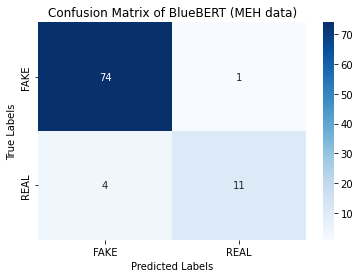

In [57]:
cm_bluebert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bluebert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT (MEH data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT_meh')

## Fine-tuning

In [58]:
# %%time
# from bert import run_classifier
params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# wrap classifier/regressor in GridSearchCV
clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
                   params,
                   cv=3,
                   scoring='accuracy',
                   verbose=True)

# fit gridsearch 
clf_bert.fit(X_train ,y_train)

Building sklearn text classifier...
Building sklearn text classifier...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.52it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.70it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.59it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.19it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.55it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.96it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.80it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.92it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.70it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.64it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.72it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.54it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  7.48it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.77it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.51it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.27it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.20it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 178, validation data size: 0


Predicting: 100%|██████████| 12/12 [00:01<00:00,  8.00it/s]


Building sklearn text classifier...
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 267, validation data size: 0


Training  : 100%|██████████| 9/9 [00:03<00:00,  2.29it/s, loss=0.089] 


GridSearchCV(cv=3,
             estimator=BertClassifier(max_seq_length=64, validation_fraction=0),
             param_grid={'epochs': [50, 75, 100],
                         'learning_rate': [2e-05, 3e-05, 1e-05]},
             scoring='accuracy', verbose=True)

In [59]:
means = clf_bert.cv_results_['mean_test_score']
stds = clf_bert.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
# best scores
print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

0.918 (+/-0.046) for {'epochs': 50, 'learning_rate': 2e-05}
0.921 (+/-0.055) for {'epochs': 50, 'learning_rate': 3e-05}
0.918 (+/-0.046) for {'epochs': 50, 'learning_rate': 1e-05}
0.921 (+/-0.049) for {'epochs': 75, 'learning_rate': 2e-05}
0.918 (+/-0.046) for {'epochs': 75, 'learning_rate': 3e-05}
0.914 (+/-0.046) for {'epochs': 75, 'learning_rate': 1e-05}
0.921 (+/-0.037) for {'epochs': 100, 'learning_rate': 2e-05}
0.918 (+/-0.038) for {'epochs': 100, 'learning_rate': 3e-05}
0.918 (+/-0.038) for {'epochs': 100, 'learning_rate': 1e-05}

Best score: 0.9213483146067416 with params: {'epochs': 50, 'learning_rate': 3e-05}


In [60]:
#define a batch size
batch_size = 5
epochs = 50
learning_rate = 3e-5

In [61]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [62]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 50


100%|██████████| 54/54 [00:01<00:00, 28.87it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.45it/s]


Training Loss: 0.767 dev performance, p:0.150, r:0.044, f1:0.068
current best score is 0.068

 Epoch 2 / 50



100%|██████████| 54/54 [00:01<00:00, 28.96it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.89it/s]


Training Loss: 0.760 dev performance, p:0.143, r:0.044, f1:0.067

 Epoch 3 / 50



100%|██████████| 54/54 [00:01<00:00, 28.91it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.61it/s]


Training Loss: 0.751 dev performance, p:0.407, r:0.162, f1:0.232
current best score is 0.232

 Epoch 4 / 50



100%|██████████| 54/54 [00:01<00:00, 29.09it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.59it/s]


Training Loss: 0.750 dev performance, p:0.280, r:0.103, f1:0.151

 Epoch 5 / 50



100%|██████████| 54/54 [00:01<00:00, 28.94it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.72it/s]


Training Loss: 0.730 dev performance, p:0.541, r:0.294, f1:0.381
current best score is 0.381

 Epoch 6 / 50



100%|██████████| 54/54 [00:01<00:00, 29.10it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.40it/s]



Training Loss: 0.734 dev performance, p:0.300, r:0.132, f1:0.184

 Epoch 7 / 50


100%|██████████| 54/54 [00:01<00:00, 29.09it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 109.44it/s]


Training Loss: 0.723 dev performance, p:0.568, r:0.309, f1:0.400
current best score is 0.400

 Epoch 8 / 50



100%|██████████| 54/54 [00:01<00:00, 29.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.84it/s]



Training Loss: 0.716 dev performance, p:0.627, r:0.471, f1:0.538
current best score is 0.538

 Epoch 9 / 50


100%|██████████| 54/54 [00:01<00:00, 29.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.86it/s]



Training Loss: 0.707 dev performance, p:0.638, r:0.441, f1:0.522

 Epoch 10 / 50


100%|██████████| 54/54 [00:01<00:00, 28.83it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.78it/s]


Training Loss: 0.698 dev performance, p:0.649, r:0.544, f1:0.592
current best score is 0.592

 Epoch 11 / 50



100%|██████████| 54/54 [00:01<00:00, 28.74it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 109.48it/s]


Training Loss: 0.691 dev performance, p:0.677, r:0.618, f1:0.646
current best score is 0.646

 Epoch 12 / 50



100%|██████████| 54/54 [00:01<00:00, 29.13it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.64it/s]



Training Loss: 0.684 dev performance, p:0.743, r:0.765, f1:0.754
current best score is 0.754

 Epoch 13 / 50


100%|██████████| 54/54 [00:01<00:00, 29.34it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.39it/s]


Training Loss: 0.681 dev performance, p:0.743, r:0.765, f1:0.754

 Epoch 14 / 50



100%|██████████| 54/54 [00:01<00:00, 29.22it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.15it/s]


Training Loss: 0.670 dev performance, p:0.753, r:0.853, f1:0.800
current best score is 0.800

 Epoch 15 / 50



100%|██████████| 54/54 [00:01<00:00, 29.02it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 106.15it/s]


Training Loss: 0.661 dev performance, p:0.787, r:0.868, f1:0.825
current best score is 0.825

 Epoch 16 / 50



100%|██████████| 54/54 [00:01<00:00, 27.53it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 106.16it/s]


Training Loss: 0.657 dev performance, p:0.795, r:0.971, f1:0.874
current best score is 0.874

 Epoch 17 / 50



100%|██████████| 54/54 [00:01<00:00, 27.82it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 99.26it/s]


Training Loss: 0.648 dev performance, p:0.774, r:0.956, f1:0.855

 Epoch 18 / 50



100%|██████████| 54/54 [00:01<00:00, 27.99it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.19it/s]


Training Loss: 0.643 dev performance, p:0.774, r:0.956, f1:0.855

 Epoch 19 / 50



100%|██████████| 54/54 [00:01<00:00, 29.03it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.19it/s]


Training Loss: 0.635 dev performance, p:0.815, r:0.971, f1:0.886
current best score is 0.886

 Epoch 20 / 50



100%|██████████| 54/54 [00:01<00:00, 29.31it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.34it/s]


Training Loss: 0.627 dev performance, p:0.850, r:1.000, f1:0.919
current best score is 0.919

 Epoch 21 / 50



100%|██████████| 54/54 [00:01<00:00, 29.09it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.06it/s]


Training Loss: 0.618 dev performance, p:0.788, r:0.985, f1:0.876

 Epoch 22 / 50



100%|██████████| 54/54 [00:01<00:00, 29.06it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.23it/s]


Training Loss: 0.614 dev performance, p:0.810, r:1.000, f1:0.895

 Epoch 23 / 50



100%|██████████| 54/54 [00:01<00:00, 29.11it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.35it/s]


Training Loss: 0.606 dev performance, p:0.819, r:1.000, f1:0.901

 Epoch 24 / 50



100%|██████████| 54/54 [00:01<00:00, 29.19it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 106.90it/s]


Training Loss: 0.600 dev performance, p:0.810, r:1.000, f1:0.895

 Epoch 25 / 50



100%|██████████| 54/54 [00:01<00:00, 29.39it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 104.33it/s]


Training Loss: 0.599 dev performance, p:0.827, r:0.985, f1:0.899

 Epoch 26 / 50



100%|██████████| 54/54 [00:01<00:00, 29.46it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 104.17it/s]


Training Loss: 0.586 dev performance, p:0.848, r:0.985, f1:0.912

 Epoch 27 / 50



100%|██████████| 54/54 [00:01<00:00, 29.36it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 105.67it/s]


Training Loss: 0.584 dev performance, p:0.810, r:1.000, f1:0.895

 Epoch 28 / 50



100%|██████████| 54/54 [00:01<00:00, 29.45it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 104.60it/s]


Training Loss: 0.574 dev performance, p:0.880, r:0.971, f1:0.923
current best score is 0.923

 Epoch 29 / 50



100%|██████████| 54/54 [00:01<00:00, 29.20it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 104.54it/s]


Training Loss: 0.575 dev performance, p:0.850, r:1.000, f1:0.919

 Epoch 30 / 50



100%|██████████| 54/54 [00:01<00:00, 28.82it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 105.66it/s]


Training Loss: 0.568 dev performance, p:0.840, r:1.000, f1:0.913

 Epoch 31 / 50



100%|██████████| 54/54 [00:01<00:00, 29.35it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 107.55it/s]


Training Loss: 0.558 dev performance, p:0.840, r:1.000, f1:0.913

 Epoch 32 / 50



100%|██████████| 54/54 [00:01<00:00, 27.52it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.15it/s]


Training Loss: 0.555 dev performance, p:0.872, r:1.000, f1:0.932
current best score is 0.932

 Epoch 33 / 50



100%|██████████| 54/54 [00:01<00:00, 27.35it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.00it/s]


Training Loss: 0.545 dev performance, p:0.782, r:1.000, f1:0.877

 Epoch 34 / 50



100%|██████████| 54/54 [00:01<00:00, 27.31it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.29it/s]


Training Loss: 0.541 dev performance, p:0.883, r:1.000, f1:0.938
current best score is 0.938

 Epoch 35 / 50



100%|██████████| 54/54 [00:01<00:00, 27.47it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.61it/s]


Training Loss: 0.538 dev performance, p:0.850, r:1.000, f1:0.919

 Epoch 36 / 50



100%|██████████| 54/54 [00:01<00:00, 27.43it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 108.43it/s]


Training Loss: 0.536 dev performance, p:0.872, r:1.000, f1:0.932

 Epoch 37 / 50



100%|██████████| 54/54 [00:01<00:00, 27.32it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.79it/s]


Training Loss: 0.523 dev performance, p:0.895, r:1.000, f1:0.944
current best score is 0.944

 Epoch 38 / 50



100%|██████████| 54/54 [00:01<00:00, 29.15it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.24it/s]


Training Loss: 0.520 dev performance, p:0.872, r:1.000, f1:0.932

 Epoch 39 / 50



100%|██████████| 54/54 [00:01<00:00, 29.33it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.45it/s]


Training Loss: 0.510 dev performance, p:0.861, r:1.000, f1:0.925

 Epoch 40 / 50



100%|██████████| 54/54 [00:01<00:00, 29.32it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.35it/s]


Training Loss: 0.507 dev performance, p:0.810, r:1.000, f1:0.895

 Epoch 41 / 50



100%|██████████| 54/54 [00:01<00:00, 29.40it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 109.12it/s]


Training Loss: 0.504 dev performance, p:0.907, r:1.000, f1:0.951
current best score is 0.951

 Epoch 42 / 50



100%|██████████| 54/54 [00:01<00:00, 29.22it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.26it/s]


Training Loss: 0.501 dev performance, p:0.883, r:1.000, f1:0.938

 Epoch 43 / 50



100%|██████████| 54/54 [00:01<00:00, 29.31it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.31it/s]


Training Loss: 0.498 dev performance, p:0.872, r:1.000, f1:0.932

 Epoch 44 / 50



100%|██████████| 54/54 [00:01<00:00, 29.35it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 110.79it/s]



Training Loss: 0.488 dev performance, p:0.882, r:0.985, f1:0.931

 Epoch 45 / 50


100%|██████████| 54/54 [00:01<00:00, 29.43it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.87it/s]


Training Loss: 0.489 dev performance, p:0.895, r:1.000, f1:0.944

 Epoch 46 / 50



100%|██████████| 54/54 [00:01<00:00, 29.41it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.32it/s]


Training Loss: 0.484 dev performance, p:0.907, r:1.000, f1:0.951

 Epoch 47 / 50



100%|██████████| 54/54 [00:01<00:00, 29.40it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 111.91it/s]


Training Loss: 0.474 dev performance, p:0.895, r:1.000, f1:0.944

 Epoch 48 / 50



100%|██████████| 54/54 [00:01<00:00, 29.37it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.13it/s]


Training Loss: 0.473 dev performance, p:0.919, r:1.000, f1:0.958


current best score is 0.958

 Epoch 49 / 50


100%|██████████| 54/54 [00:01<00:00, 29.18it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.28it/s]


Training Loss: 0.468 dev performance, p:0.883, r:1.000, f1:0.938

 Epoch 50 / 50



100%|██████████| 54/54 [00:01<00:00, 29.45it/s]

evaluating...



100%|██████████| 18/18 [00:00<00:00, 112.26it/s]


Training Loss: 0.466 dev performance, p:0.919, r:1.000, f1:0.958


In [63]:
model_file = 'MEH_bluebert_gridsearch.pt'
torch.save(best_model_state, model_file)

In [64]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'MEH_bluebert_gridsearch.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

In [65]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [66]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|██████████| 18/18 [00:00<00:00, 111.33it/s]

{'precision': 0.8928571428571429, 'recall': 1.0, 'f1': 0.9433962264150945}


In [67]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64        15
           1       0.90      1.00      0.95        75

    accuracy                           0.91        90
   macro avg       0.95      0.73      0.79        90
weighted avg       0.92      0.91      0.90        90



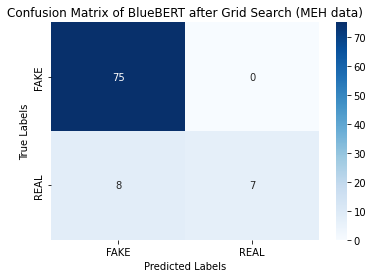

In [68]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT after Grid Search (MEH data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT(grid search)_meh')